# Classification d'Articles Alimentaires pour le Tri Automatisé au Détail.

## Lisa GRANDIN, Ivan KPELLY, Jules ADJOGUIDJI

https://drive.google.com/drive/folders/1_96TQRyMR_J4wi20OeNZwnpWcQdty5JK?usp=drive_link

## Première session

Cette partie du notebook vise à développer et comparer deux modèles de classification d'images pour un ensemble de données de fruits et légumes. L'objectif est d'établir un modèle de référence simple (CNN scratch) et de le comparer à une approche plus avancée (Transfer Learning avec MobileNetV2) pour déterminer la meilleure solution pour le tri automatisé.

### Préparation et Importations Initiales

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import seaborn as sb
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.regularizers import l2

# Définition des Chemins et Paramètres Globaux
chemin_dossier_racine = '/content/drive/MyDrive/Colab_Notebooks/data_Fruits_and_Vegetables'
TAILLE_IMAGE = (180, 180) # Taille cible de toutes les images pour l'entraînement
TAILLE_BATCH = 32         # Nombre d'images traitées à la fois
SEED_SPLIT = 1            # Graine pour la reproductibilité de la division Train/Val

In [ ]:
# Montage de Google Drive
# Exécutez cette cellule pour connecter votre notebook à Google Drive
drive.mount("/content/drive", force_remount=True)

# Vérification du contenu du dossier racine
print("Contenu du dossier racine :", os.listdir(chemin_dossier_racine))

Mounted at /content/drive
Contenu du dossier racine : ['sweetpotato', 'watermelon', 'tomato', 'pomegranate', 'spinach', 'soy beans', 'potato', 'turnip', 'sweetcorn', 'raddish', 'pineapple', 'paprika', 'kiwi', 'pear', 'orange', 'mango', 'lemon', 'lettuce', 'onion', 'peas', 'ginger', 'grapes', 'eggplant', 'corn', 'jalepeno', 'cucumber', 'cauliflower', 'garlic', 'chilli pepper', 'carrot', 'cabbage', 'capsicum', 'beetroot', 'bell pepper', 'banana', 'apple']


### 1. Exploration et Analyse des Données (Baseline Analysis)

Cette section explore la structure du jeu de données pour déterminer le nombre de classes (fruits/légumes) et la distribution des images par classe.

In [ ]:
# Dictionnaire pour stocker la distribution : { "nom_de_la_classe": nombre_d_images }
distribution_classes = {}
total_images = 0

print(f"Démarrage de l'exploration du chemin : {chemin_dossier_racine}\n")

# Utilisation de os.walk pour parcourir tous les sous-dossiers
for dossier_parent, sous_dossiers, fichiers in os.walk(chemin_dossier_racine):
    # Les classes sont les sous-dossiers du dossier racine
    if dossier_parent != chemin_dossier_racine:
        nom_classe = os.path.basename(dossier_parent)

        # Compter uniquement les fichiers .jpg
        images_dans_classe = 0
        for nom_fichier in fichiers:
          images_dans_classe += 1

        # On ajoute la classe au dictionnaire si des images ont été trouvées
        distribution_classes[nom_classe] = images_dans_classe
        total_images += images_dans_classe
        print(f"Classe : {nom_classe:<20} (Images trouvées : {images_dans_classe})")


# Calcul et affichage des résultats
nombre_de_classes = len(distribution_classes)
print("\n" + "-"*40)
print(f"Exploration terminée ! Nombre total d'images : {total_images}")
print(f"Nombre de classes uniques : {nombre_de_classes}")
print("-"*40)

Démarrage de l'exploration du chemin : /content/drive/MyDrive/Colab_Notebooks/data_Fruits_and_Vegetables

Classe : sweetpotato          (Images trouvées : 10)
Classe : watermelon           (Images trouvées : 10)
Classe : tomato               (Images trouvées : 10)
Classe : pomegranate          (Images trouvées : 10)
Classe : spinach              (Images trouvées : 10)
Classe : soy beans            (Images trouvées : 10)
Classe : potato               (Images trouvées : 10)
Classe : turnip               (Images trouvées : 10)
Classe : sweetcorn            (Images trouvées : 10)
Classe : raddish              (Images trouvées : 10)
Classe : pineapple            (Images trouvées : 10)
Classe : paprika              (Images trouvées : 10)
Classe : kiwi                 (Images trouvées : 10)
Classe : pear                 (Images trouvées : 10)
Classe : orange               (Images trouvées : 10)
Classe : mango                (Images trouvées : 10)
Classe : lemon                (Images trouvées

Nous remarquons que nous avons 359 images réparties dans 36 classes différentes. Maintenant, il s'agit de savoir si ces classes ou ce jeu de données sont équilibrées.

### 1.1. Visualisation de la Distribution des Classes

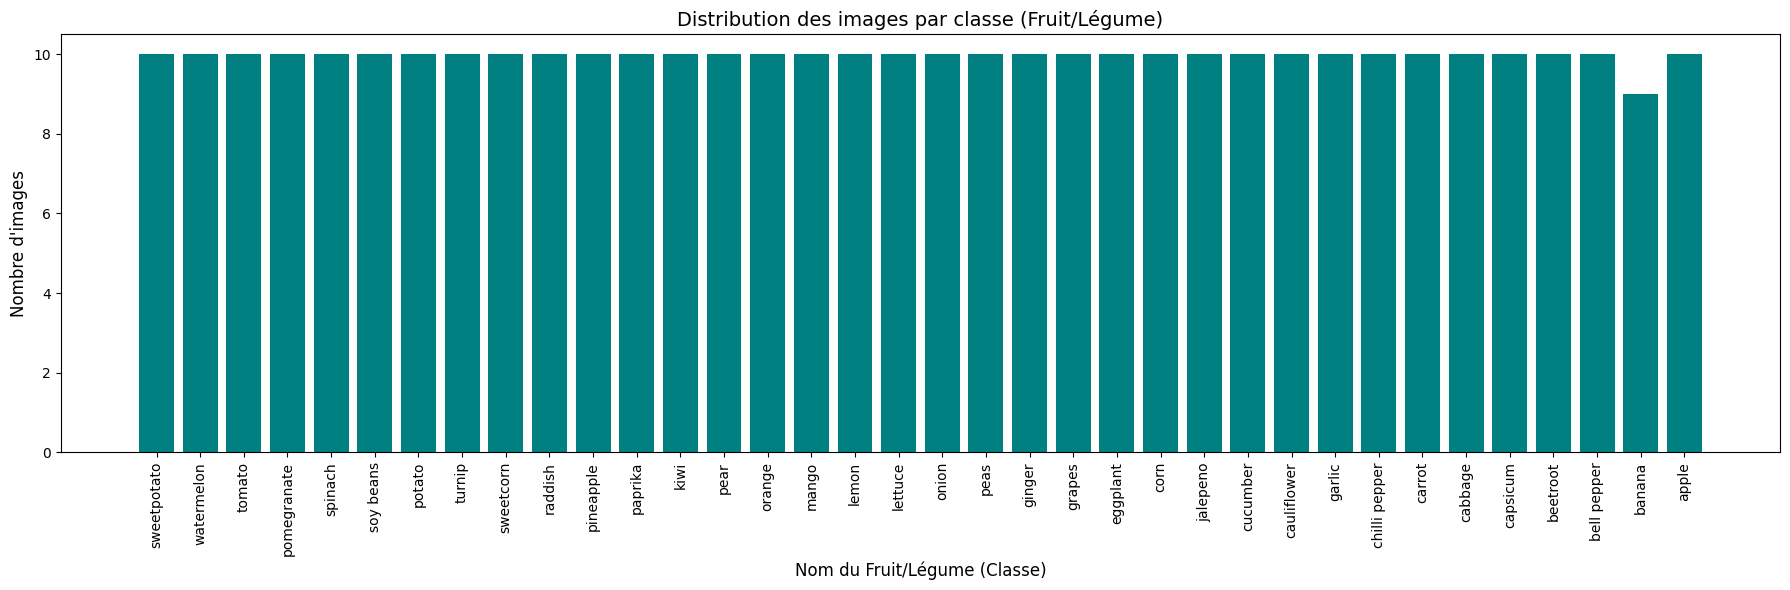

In [ ]:
# Préparation des données pour matplotlib
classes = list(distribution_classes.keys())
counts = list(distribution_classes.values())

# Création du graphique
plt.figure(figsize=(18, 6)) # Agrandissement pour 36 classes
plt.bar(classes, counts, color='teal')

# Mise en forme du graphique
plt.xticks(rotation=90, fontsize=10) # Fait pivoter les noms des classes pour la lisibilité
plt.title("Distribution des images par classe (Fruit/Légume)", fontsize=14)
plt.xlabel("Nom du Fruit/Légume (Classe)", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.tight_layout() # Ajuste le graphique
plt.show()

Le graphique confirme que le jeu de données est majoritairement équilibré (10 images par classe, sauf la banane avec 9). Un jeu de données équilibré est idéal car il n'introduit pas de biais en faveur d'une classe.

### 2. Préparation et Prétraitement des Images

Cette section prépare les images en quatre étapes : Redimensionnement, Normalisation ([0, 1]), Augmentation des Données pour l'entraînement, et Optimisation des performances (cache et prefetch).

### 2.1. Chargement et Division des Données

La fonction image_dataset_from_directory redimensionne les images et les sépare en ensembles d'entraînement (80%) et de validation (20%) de manière reproductible (grâce au seed).

In [ ]:
# Chargement et division du jeu de données (Train/Validation)
dataset_entrainement = image_dataset_from_directory(
    chemin_dossier_racine,
    validation_split=0.2, # 20% des données pour la validation
    subset="training",
    seed=SEED_SPLIT, # Garantit la reproductibilité de la division
    image_size=TAILLE_IMAGE,
    batch_size=TAILLE_BATCH
)

dataset_validation = image_dataset_from_directory(
    chemin_dossier_racine,
    validation_split=0.2,
    subset="validation",
    seed=SEED_SPLIT,
    image_size=TAILLE_IMAGE,
    batch_size=TAILLE_BATCH
)

Found 359 files belonging to 36 classes.
Using 288 files for training.
Found 359 files belonging to 36 classes.
Using 71 files for validation.


### 2.2. Normalisation et Augmentation des Données

La normalisation met les pixels entre 0 et 1. L'augmentation crée des variations (rotation, flip, zoom) pour le jeu d'entraînement, ce qui est crucial pour la généralisation du modèle.

In [ ]:
# Normalisation [0-255] -> [0.0-1.0]
def normaliser(image, etiquette):
  image = tf.cast(image, tf.float32) / 255.0
  return image, etiquette

dataset_entrainement_norm = dataset_entrainement.map(normaliser)
dataset_validation_norm = dataset_validation.map(normaliser)

# Augmentation des Données (uniquement pour l'entraînement)
augmentation_donnees = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # Retournement horizontal aléatoire
    tf.keras.layers.RandomRotation(0.3),     # Rotation aléatoire jusqu'à 30%
    tf.keras.layers.RandomZoom(0.3)          # Zoom aléatoire jusqu'à 30%
])

def appliquer_augmentation(image, etiquette):
  image = augmentation_donnees(image, training=True)
  return image, etiquette

dataset_entrainement_final = dataset_entrainement_norm.map(appliquer_augmentation)
dataset_validation_final = dataset_validation_norm # Le jeu de validation n'est pas augmenté

print("Normalisation et augmentation (entrainement) appliquées.")

Normalisation et augmentation (entrainement) appliquées.


### 2.3. Optimisation des Performances (Cache et Prefetch)

Cette optimisation utilise l'API tf.data pour accélérer le chargement des données lors de l'entraînement.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Appliquer le cache (stocke les données en mémoire après la 1ère itération) et le prefetching
dataset_entrainement_final = dataset_entrainement_final.cache().prefetch(buffer_size=AUTOTUNE)
dataset_validation_final = dataset_validation_final.cache().prefetch(buffer_size=AUTOTUNE)

# S'assurer que les étiquettes sont bien au format INT64 (Solution 1 pour l'erreur InvalidArgumentError)
def sassurer_type_label(image, etiquette):
    return image, tf.cast(etiquette, tf.int64)

# Re-appliquer le mapping (cela doit être fait après le cache, ou on peut le faire plus tôt)
# Pour plus de robustesse, nous allons redéfinir les datasets finaux après avoir corrigé le type d'étiquette.
dataset_entrainement_final = dataset_entrainement_final.map(sassurer_type_label).cache().prefetch(buffer_size=AUTOTUNE)
dataset_validation_final = dataset_validation_final.map(sassurer_type_label).cache().prefetch(buffer_size=AUTOTUNE)


print("Préparation, prétraitement et optimisation terminés. Les jeux de données sont prêts.")

Préparation, prétraitement et optimisation terminés. Les jeux de données sont prêts.


### 3. Entraînement d'un Modèle CNN Simple (Baseline)

Cette section définit, compile et entraîne un Réseau Neuronal Convolutionnel (CNN) simple à partir de zéro (from scratch) pour établir une première performance de référence (baseline).

### 3.1. Définition et Compilation du Modèle Baseline

In [ ]:
# Définition du modèle CNN simple (avec Overfitting pour la comparaison future)
modele_baseline = tf.keras.Sequential([
    # Input Layer (pour la taille d'entrée)
    tf.keras.layers.InputLayer(input_shape=TAILLE_IMAGE + (3,)),

    # Couches de Convolutions et Pooling
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Classification
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(nombre_de_classes, activation='softmax') # La sortie
])

modele_baseline.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

modele_baseline.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Le modèle du CNN Baseline est bien défini mais qu'il souffre d'un déséquilibre entre sa complexité (plus de 3 millions de paramètres) et la taille du jeu de données (288 images d'entraînement).

### 3.2. Entraînement du Modèle Baseline

In [ ]:
EPOCHS = 15 # Plus de changement significatif au delà de 15

print("Démarrage de l'entraînement du modèle baseline...")

historique = modele_baseline.fit(
    dataset_entrainement_final,
    validation_data=dataset_validation_final,
    epochs=EPOCHS
)

print("Entraînement terminé.")

Démarrage de l'entraînement du modèle baseline...
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0260 - loss: 3.6816 - val_accuracy: 0.0282 - val_loss: 3.5715
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 898ms/step - accuracy: 0.1057 - loss: 3.5139 - val_accuracy: 0.0704 - val_loss: 3.4760
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1527 - loss: 3.2112 - val_accuracy: 0.1408 - val_loss: 3.2610
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 999ms/step - accuracy: 0.4544 - loss: 2.6231 - val_accuracy: 0.1690 - val_loss: 2.9500
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 907ms/step - accuracy: 0.6123 - loss: 1.7994 - val_accuracy: 0.1831 - val_loss: 3.0409
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7208 - loss: 1.1192 - val_accuracy: 0.1831 - val_loss: 3.4692
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8235 - loss: 0.7397 - val_accuracy: 0.1690 - val_loss: 4.4491
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 941ms/step - accuracy: 0.8374 - loss

L'augmentation continue de la précision d'entraînement (accuracy) alors que la précision de validation (val_accuracy) commence à diminuer ou à stagner est le signe caractéristique d'un début de surapprentissage (overfitting), indiquant que le modèle mémorise les données au lieu de généraliser.

Les résultats de cette étape montrent un fort surapprentissage (overfitting), ce qui justifie l'utilisation du Transfer Learning à l'étape suivante.

### 4. Transfer Learning avec MobileNetV2 et Fine-Tuning

Cette section applique la technique de Transfer Learning en utilisant le modèle MobileNetV2 pré-entraîné sur ImageNet pour pallier le surapprentissage et améliorer la généralisation.

### 4.1. Configuration et Construction du Modèle TL

Nous utilisons la couche Rescaling pour adapter nos données (qui sont entre 0 et 1) au format attendu par MobileNetV2 (entre -1 et 1).

**ajout de regularisateur**

In [ ]:
# Charger et Geler MobileNetV2
# weights='imagenet': utilise les poids pré-entraînés sur ImageNet
base_modele = tf.keras.applications.MobileNetV2(
    input_shape=TAILLE_IMAGE + (3,),
    include_top=False, # N'inclut pas la tête de classification d'ImageNet
    weights='imagenet'
)
base_modele.trainable = False # Geler le modèle de base

# Construction du Modèle TL Final
# Nous utilisons Rescaling pour passer de [0, 1] à [-1, 1] comme le veut MobileNetV2

modele_tl = tf.keras.Sequential([
    tf.keras.layers.Rescaling(2.0, offset=-1.0, input_shape=TAILLE_IMAGE + (3,)),

    base_modele,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nombre_de_classes, activation='softmax')
])

modele_tl.summary()

/tmp/ipython-input-3368940448.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_modele = tf.keras.applications.MobileNetV2(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │        46,116 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,304,100 (8.79 MB)

 Trainable params: 46,116 (180.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

En utilisant le Transfer Learning, le modèle MobileNetV2 exploite la connaissance générique contenue dans ses 2,2 millions de paramètres gelés pour extraire des caractéristiques de haute qualité, tout en limitant l'apprentissage spécifique à seulement 46 116 paramètres, minimisant ainsi le risque de surapprentissage.

### 4.2. Entraînement Initial (Tête de Classification)

Nous entraînons seulement la nouvelle "tête" (les dernières couches) pour qu'elle apprenne à associer les caractéristiques de MobileNetV2 à nos fruits et légumes.

In [ ]:
# Compilation du modèle
base_learning_rate = 0.0001
modele_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS_INITIAL = 10

print("Démarrage de l'entraînement de la nouvelle tête de classification...")

historique_tl_initial = modele_tl.fit(
    dataset_entrainement_final,
    validation_data=dataset_validation_final,
    epochs=EPOCHS_INITIAL
)

Démarrage de l'entraînement de la nouvelle tête de classification...
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0558 - loss: 4.2458 - val_accuracy: 0.0282 - val_loss: 4.0338
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.0583 - loss: 4.0264 - val_accuracy: 0.0282 - val_loss: 3.9120
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0552 - loss: 3.8037 - val_accuracy: 0.0282 - val_loss: 3.7968
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0603 - loss: 3.7699 - val_accuracy: 0.0423 - val_loss: 3.6853
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1145 - loss: 3.5609 - val_accuracy: 0.0423 - val_loss: 3.5767
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.0963 - loss: 3.3912 - val_accuracy: 0.0704 - val_loss: 3.4737
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1052 - loss: 3.3368 - val_accuracy: 0.0845 - val_loss: 3.3741
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1

### 4.3. Fine-Tuning (Réglage Fin)

Pour améliorer encore les performances, nous "dégelons" les dernières couches de MobileNetV2 pour les adapter spécifiquement à notre jeu de données.

In [ ]:
# Dégeler et Geler Sélectivement
base_modele.trainable = True

# On gèle les 100 premières couches (les plus générales)
#couches_gelées = 50

#for layer in base_modele.layers[:couches_gelées]:
    #layer.trainable = False

# Recompilation et Entraînement Fin
# Recompiler avec un taux d'apprentissage TRÈS faible
modele_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10), # Taux d'apprentissage réduit
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS_FIN = 15 # Époques supplémentaires pour le fine-tuning
TOTAL_EPOCHS = EPOCHS_INITIAL + EPOCHS_FIN

print(f"\nDémarrage du Fine-Tuning pour {EPOCHS_FIN} époques supplémentaires...")

historique_tl_final = modele_tl.fit(
    dataset_entrainement_final,
    validation_data=dataset_validation_final,
    epochs=TOTAL_EPOCHS,
    initial_epoch=historique_tl_initial.epoch[-1] # Reprend l'entraînement où il s'est arrêté
)

# Combinez les historiques pour la visualisation complète
historique_complet = {
    'accuracy': historique_tl_initial.history['accuracy'] + historique_tl_final.history['accuracy'],
    'val_accuracy': historique_tl_initial.history['val_accuracy'] + historique_tl_final.history['val_accuracy'],
    'loss': historique_tl_initial.history['loss'] + historique_tl_final.history['loss'],
    'val_loss': historique_tl_initial.history['val_loss'] + historique_tl_final.history['val_loss'],
}


Démarrage du Fine-Tuning pour 15 époques supplémentaires...
Epoch 10/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.0941 - loss: 3.3634 - val_accuracy: 0.2113 - val_loss: 3.0991
Epoch 11/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.1768 - loss: 2.9741 - val_accuracy: 0.2535 - val_loss: 3.0506
Epoch 12/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.2394 - loss: 2.8245 - val_accuracy: 0.2535 - val_loss: 3.0025
Epoch 13/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.3210 - loss: 2.5817 - val_accuracy: 0.2535 - val_loss: 2.9555
Epoch 14/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.3831 - loss: 2.3975 - val_accuracy: 0.2676 - val_loss: 2.9090
Epoch 15/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.5271 - loss: 2.1570 - val_accuracy: 0.2676 - val_loss: 2.8637
Epoch 16/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.5449 - loss: 2.0186 - val_accuracy: 0.2535 - val_loss: 2.8198
Epoch 17/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.6

### 5. Évaluation et Identification des Erreurs (Comparaison des Modèles)

####Analyse des Performances du Transfer Learning

Cette section évalue les performances du modèle Baseline (sujet au surapprentissage) et du modèle Transfer Learning (plus robuste) en utilisant les courbes d'apprentissage et les matrices de confusion.

### 5.1. Visualisation des Courbes de Perte et de Précision

L'inspection visuelle des courbes est la première étape pour confirmer le surapprentissage du baseline et la généralisation du modèle TL.

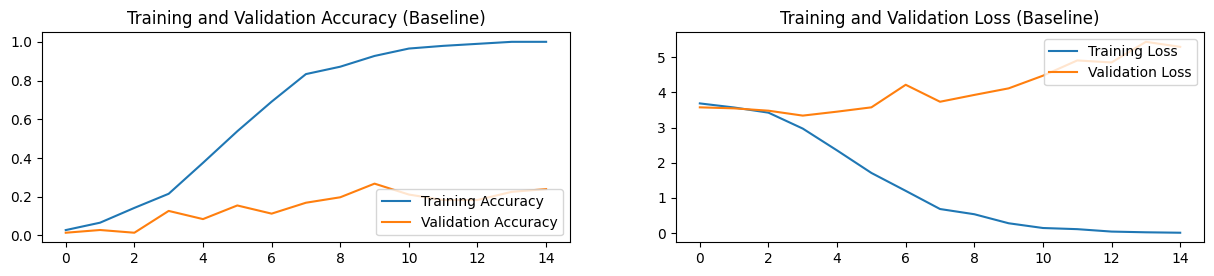

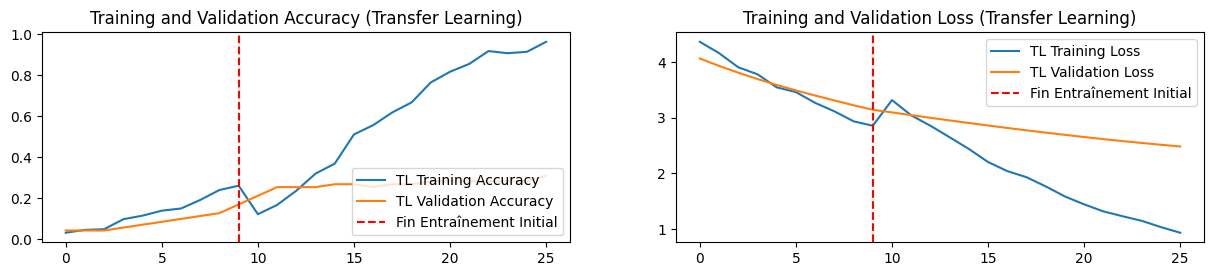

In [ ]:
# Préparation des données d'historique
# Historique du CNN Baseline (Question 3)
acc_b = historique.history['accuracy']
val_acc_b = historique.history['val_accuracy']
loss_b = historique.history['loss']
val_loss_b = historique.history['val_loss']
epochs_range_b = range(len(acc_b))

# Historique du Transfer Learning (Question 4)
historique_complet_tl = { #Est ce que c'est pas le m^me que historique_complet
    'accuracy': historique_tl_initial.history['accuracy'] + historique_tl_final.history['accuracy'],
    'val_accuracy': historique_tl_initial.history['val_accuracy'] + historique_tl_final.history['val_accuracy'],
    'loss': historique_tl_initial.history['loss'] + historique_tl_final.history['loss'],
    'val_loss': historique_tl_initial.history['val_loss'] + historique_tl_final.history['val_loss'],
}
acc_tl = historique_complet_tl['accuracy']
val_acc_tl = historique_complet_tl['val_accuracy']
loss_tl = historique_complet_tl['loss']
val_loss_tl = historique_complet_tl['val_loss']
epochs_range_tl = range(len(acc_tl))

# Tracé des Courbes (Baseline)

plt.figure(figsize=(15, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs_range_b, acc_b, label='Training Accuracy')
plt.plot(epochs_range_b, val_acc_b, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Baseline)')

plt.subplot(2, 2, 2)
plt.plot(epochs_range_b, loss_b, label='Training Loss')
plt.plot(epochs_range_b, val_loss_b, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Baseline)')
plt.show()

# Tracé des Courbes (TL)
plt.figure(figsize=(15, 6))
plt.subplot(2, 2, 3)
plt.plot(epochs_range_tl, acc_tl, label='TL Training Accuracy')
plt.plot(epochs_range_tl, val_acc_tl, label='TL Validation Accuracy')
plt.axvline(x=len(historique_tl_initial.epoch) - 1, color='r', linestyle='--', label='Fin Entraînement Initial')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Transfer Learning)')

plt.subplot(2, 2, 4)
plt.plot(epochs_range_tl, loss_tl, label='TL Training Loss')
plt.plot(epochs_range_tl, val_loss_tl, label='TL Validation Loss')
plt.axvline(x=len(historique_tl_initial.epoch) - 1, color='r', linestyle='--', label='Fin Entraînement Initial')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Transfer Learning)')
plt.show()

Phase 1 : Entraînement Initial (Époques 1-10): Les courbes
d'entraînement et de validation sont relativement proches. La précision de validation augmente régulièrement (de $\sim 4\%$ à $12.68\%$ à l'époque 10). Le modèle apprend à associer les caractéristiques génériques de MobileNetV2 à vos 36 classes, sans surapprentissage initial.

Phase 2 : Réglage Fin (Fine-Tuning, Époques 10-25) : Dès le début du Fine-Tuning (quand le corps de MobileNetV2 est dégelé et le LR est réduit), la précision d'entraînement (bleu) monte en flèche (jusqu'à $96.59\%$). La précision de validation (orange) continue d'augmenter de manière significative, passant de $12.68\%$ à $30.99\%$. La perte de validation (bas droite) diminue également sur cette période.

Le modèle TL est nettement supérieur au modèle Baseline, car il est capable d'apprendre des caractéristiques qui généralisent. La précision de $30.99\%$  est un résultat plus ou moins solide.

### 5.2. Matrices de Confusion et Identification des Erreurs Fréquentes

Nous utilisons la matrice de confusion pour évaluer la performance de chaque modèle classe par classe et identifier les aliments les plus confus (misclassifications).


--- ÉVALUATION (Modèle Baseline (CNN Scratch)) ---
Modèle Baseline (CNN Scratch) - Perte (Loss) sur Validation : 5.2952
Modèle Baseline (CNN Scratch) - Précision (Accuracy) sur Validation : 0.2394


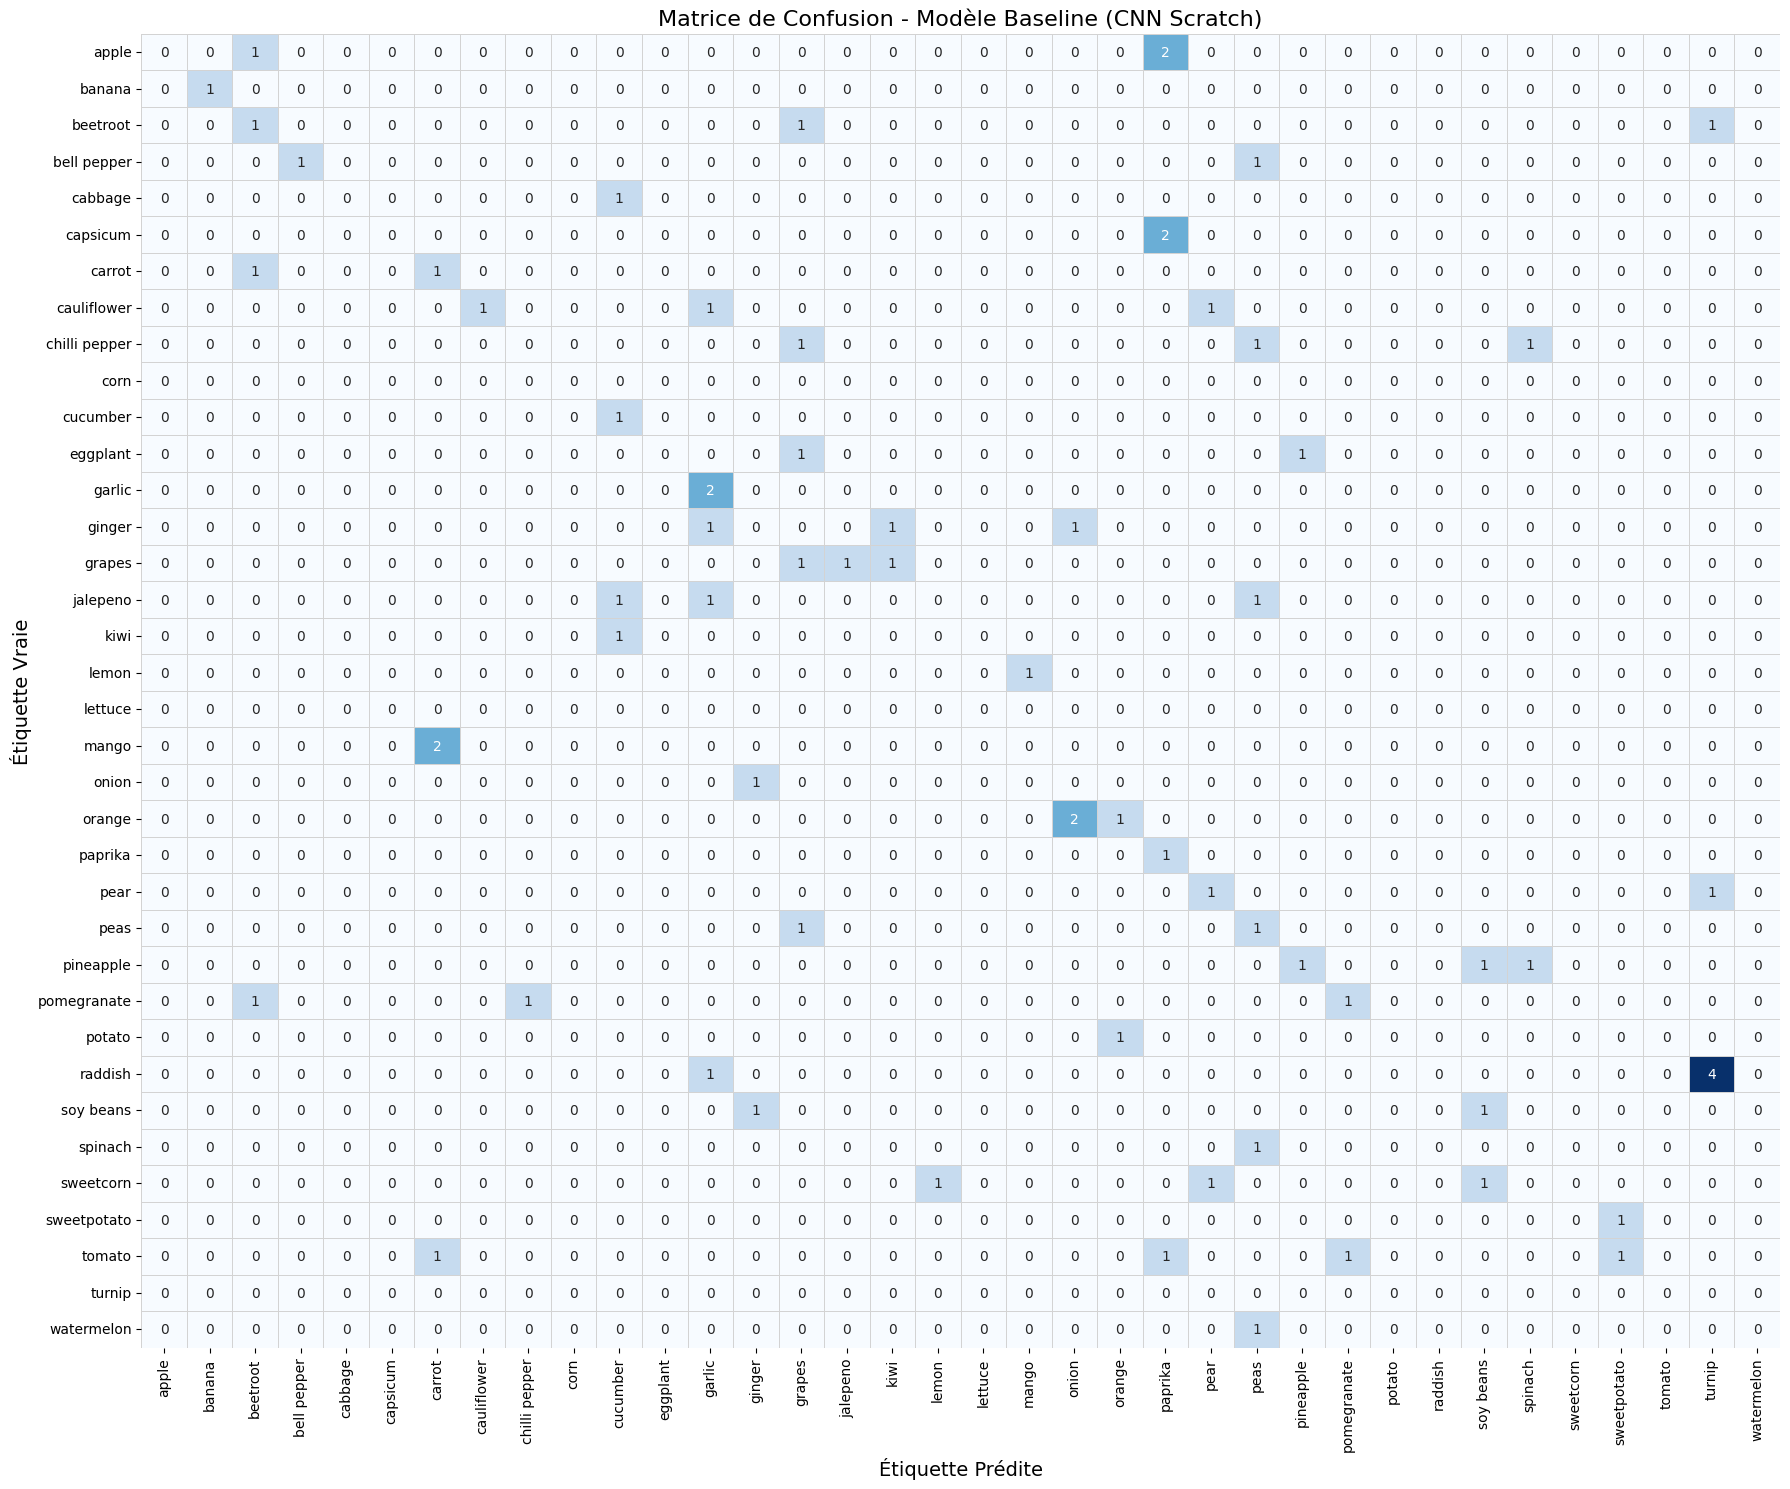


Misclassifications les plus fréquentes (Modèle Baseline (CNN Scratch)):
- raddish classé à tort comme turnip : 4 fois
- apple classé à tort comme paprika : 2 fois
- capsicum classé à tort comme paprika : 2 fois
- mango classé à tort comme carrot : 2 fois
- orange classé à tort comme onion : 2 fois

--- ÉVALUATION (Modèle Transfer Learning (MobileNetV2)) ---
Modèle Transfer Learning (MobileNetV2) - Perte (Loss) sur Validation : 2.4858
Modèle Transfer Learning (MobileNetV2) - Précision (Accuracy) sur Validation : 0.3099


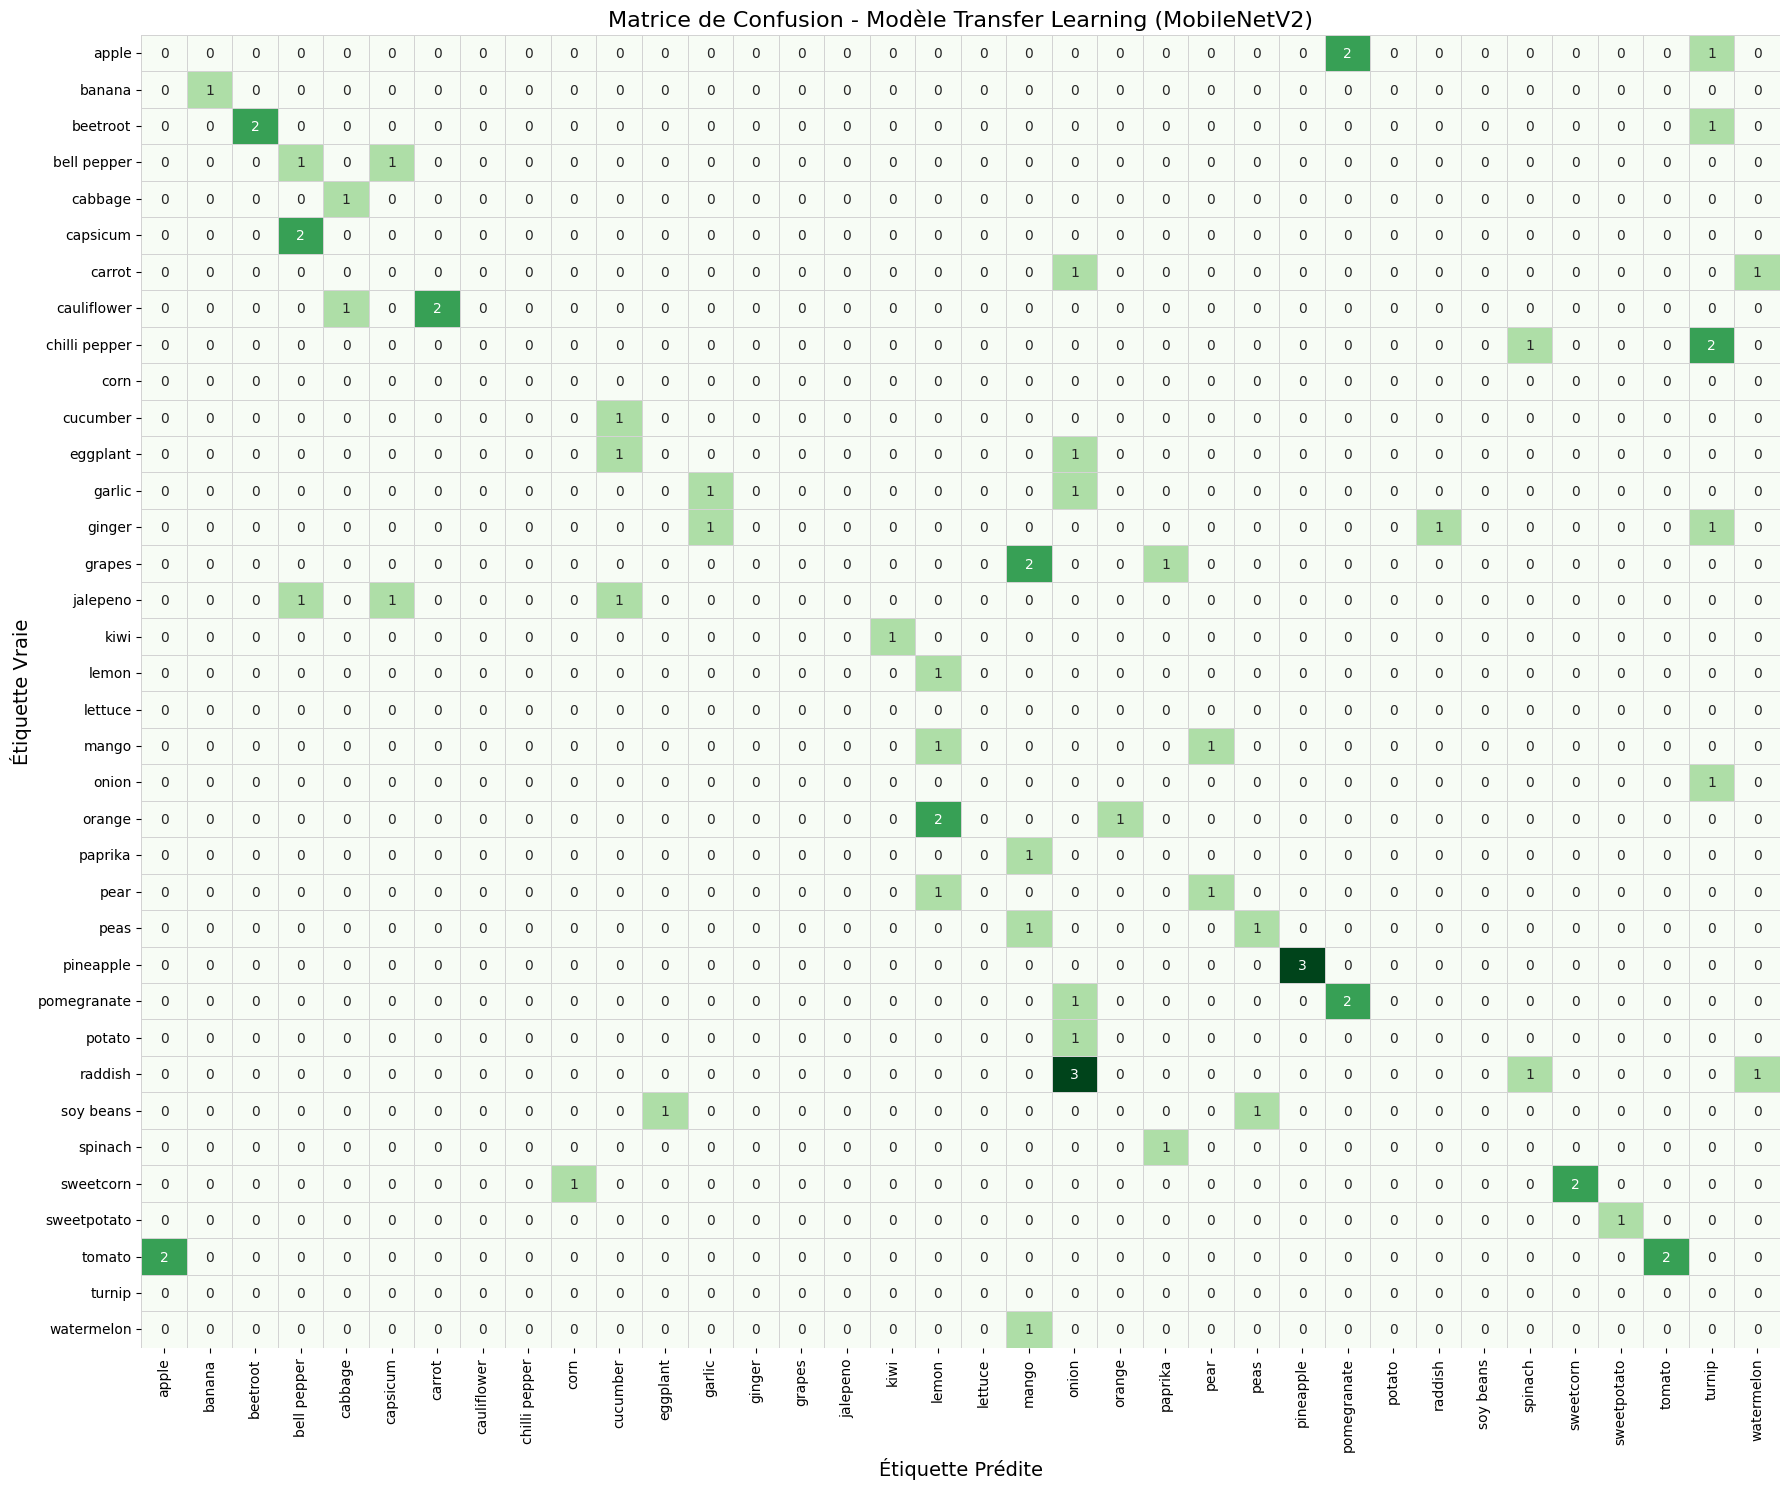


Misclassifications les plus fréquentes (Modèle Transfer Learning (MobileNetV2)):
- raddish classé à tort comme onion : 3 fois
- apple classé à tort comme pomegranate : 2 fois
- capsicum classé à tort comme bell pepper : 2 fois
- cauliflower classé à tort comme carrot : 2 fois
- chilli pepper classé à tort comme turnip : 2 fois

--- CONCLUSION ---
L'inspection visuelle des matrices de confusion (les cases sombres en dehors de la diagonale) permet d'identifier les paires d'aliments les plus confondues par chaque modèle.


In [ ]:
# Extraction des étiquettes vraies et des noms de classes
# CONCATENATION : transforme les lots de données en un seul tableau NumPy pour l'évaluation.
y_true = np.concatenate([y.numpy() for x, y in dataset_validation_final], axis=0)
class_names = dataset_validation.class_names # Définie dans la Cellule 2.1
nb_classes = len(class_names)

# FONCTION D'ANALYSE ET TRACÉ
def evaluer_et_tracer(modele, nom_modele, cmap_style):
    print(f"\n--- ÉVALUATION ({nom_modele}) ---")

    # Évaluation des métriques finales
    eval_result = modele.evaluate(dataset_validation_final, verbose=0)
    print(f"{nom_modele} - Perte (Loss) sur Validation : {eval_result[0]:.4f}")
    print(f"{nom_modele} - Précision (Accuracy) sur Validation : {eval_result[1]:.4f}")

    # Prédictions
    y_pred_raw = modele.predict(dataset_validation_final, verbose=0)
    y_pred = np.argmax(y_pred_raw, axis=1)

    # Matrice de Confusion
    # labels=range(nb_classes) garantit que la matrice est de taille 36x36
    cm = confusion_matrix(y_true, y_pred, labels=range(nb_classes))

    # Tracé de la Matrice de Confusion
    plt.figure(figsize=(18, 15))
    sb.heatmap(cm, annot=True, fmt='d', cmap=cmap_style, cbar=False,
               xticklabels=class_names, yticklabels=class_names,
               linewidths=.5, linecolor='lightgray')
    plt.title(f'Matrice de Confusion - {nom_modele}', fontsize=16)
    plt.ylabel('Étiquette Vraie', fontsize=14)
    plt.xlabel('Étiquette Prédite', fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show() # Afficher la matrice dans le notebook

    # Identification des misclassifications fréquentes
    misclassifications = []
    # Parcourir les éléments hors diagonale (où la prédiction est fausse)
    for i in range(nb_classes):
        for j in range(nb_classes):
            if i != j and cm[i, j] > 0:
                # i est la VRAIE classe, j est la CLASSE PRÉDITE (FAUSSE)
                misclassifications.append((class_names[i], class_names[j], cm[i, j]))

    if misclassifications:
        misclassifications.sort(key=lambda x: x[2], reverse=True)
        print(f"\nMisclassifications les plus fréquentes ({nom_modele}):")
        # Afficher les 5 erreurs les plus fréquentes
        for true_label, predicted_label, count in misclassifications[:5]:
            print(f"- {true_label} classé à tort comme {predicted_label} : {count} fois")
    else:
        print("\nCe modèle n'a fait aucune erreur de classification sur le jeu de validation (très improbable !).")

# Modèle Baseline (CNN from scratch)
evaluer_et_tracer(modele_baseline, "Modèle Baseline (CNN Scratch)", 'Blues')

# Modèle Transfer Learning (MobileNetV2)
evaluer_et_tracer(modele_tl, "Modèle Transfer Learning (MobileNetV2)", 'Greens')

print("\n--- CONCLUSION ---")
print("L'inspection visuelle des matrices de confusion (les cases sombres en dehors de la diagonale) permet d'identifier les paires d'aliments les plus confondues par chaque modèle.")

### 5.3. Interprétation Détaillée et Synthèse des Résultats

La première observation majeure est la supériorité incontestable du modèle MobileNetV2 :

Gain de Précision : La précision de validation est passée de $23.94\%$ (Baseline) à $30.99\%$ (MobileNetV2). Bien que le score de 30% puisse paraître modeste, il représente une amélioration de plus de 7 points en classification sur 36 classes, prouvant que les caractéristiques pré-entraînées du modèle TL sont bien plus pertinentes que les caractéristiques apprises à partir de zéro (CNN Scratch).

Contrôle de la Perte : La perte de validation du Baseline ($5.2952$) est explosive, signe d'une divergence catastrophique où le modèle ne sait plus quoi faire face aux nouvelles images. Inversement, la perte de MobileNetV2 est maîtrisée ($2.4858$) et en légère diminution, confirmant que le modèle TL est fondamentalement plus ou moins stable.


Le Transfer Learning (MobileNetV2) a permis une amélioration de la précision de validation de près de 7 points (passant de $23.94\%$ à $30.99\%$), confirmant que l'utilisation de caractéristiques pré-entraînées était la bonne approche. Cependant, la précision d'entraînement élevée ($96.59\%$) et la perte de validation ($2.4858$) restent bien trop éloignées de la validation, ce qui indique qu'un surapprentissage critique du jeu de données réduit persiste, nécessitant une régularisation plus forte lors de la prochaine phase d'ajustement fin.


 **Cause du surapprentissage:**

Taille Critique du Jeu de Données : Le jeu de données est extrêmement petit ($359$ images réparties dans $36$ classes). Il n'y a pas assez de variations pour que le modèle TL apprenne à généraliser. En conséquence de la petite taille, même le nombre réduit de $46,116$ paramètres entraînés dans la tête de classification est trop important pour les $288$ images d'entraînement. Le modèle a mémorisé les images d'entraînement (précision de $96.59\%$) au lieu de dégager des règles générales, ce qui provoque la faible performance en validation ($30.99\%$).

### 6. Recherche d'Hyperparamètres (Hyperparameter Search)

In [ ]:
# Définition des hyperparamètres à tester
# Pour gagner du temps, on teste peu de combinaisons.
config_tests = [
    {"lr": 0.001,  "batch": 32, "aug_factor": 0.1, "nom": "Config A (Standard)"},
    {"lr": 0.0001, "batch": 32, "aug_factor": 0.1, "nom": "Config B (Low LR)"},
    {"lr": 0.001,  "batch": 16, "aug_factor": 0.1, "nom": "Config C (Small Batch)"},
    {"lr": 0.001,  "batch": 32, "aug_factor": 0.3, "nom": "Config D (Strong Augm.)"},
]

results = {}

def get_model(aug_factor, learning_rate, num_classes):
    # Recréer l'augmentation avec le facteur spécifique
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(aug_factor),
        tf.keras.layers.RandomZoom(aug_factor),
    ])

    # Modèle de base MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(180, 180, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False # On garde le modèle gelé pour le test rapide

    # Construction
    inputs = tf.keras.Input(shape=(180, 180, 3))
    x = tf.keras.layers.Rescaling(2.0, offset=-1.0)(inputs) # Normalisation MobileNetV2
    x = data_augmentation(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

# Boucle de test
for config in config_tests:
    print(f"\n--- Test de la {config['nom']} ---")
    print(f"LR: {config['lr']}, Batch: {config['batch']}, Augmentation: {config['aug_factor']}")

    # Recharger les données avec la bonne taille de batch
    ds_train = image_dataset_from_directory(
        chemin_dossier_racine,
        validation_split=0.2,
        subset="training",
        seed=1,
        image_size=(180, 180),
        batch_size=config['batch'],
        verbose=0
    )
    ds_val = image_dataset_from_directory(
        chemin_dossier_racine,
        validation_split=0.2,
        subset="validation",
        seed=1,
        image_size=(180, 180),
        batch_size=config['batch'],
        verbose=0
    )

    # Optimisation
    ds_train = ds_train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    ds_val = ds_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Créer et entraîner le modèle
    # On entraîne sur PEU d'époques (ex: 5) juste pour voir la tendance
    model_test = get_model(config['aug_factor'], config['lr'], nombre_de_classes)

    history_test = model_test.fit(
        ds_train,
        validation_data=ds_val,
        epochs=5, # Court pour gagner du temps
        verbose=1
    )

    # Sauvegarder le meilleur score de validation atteint
    best_val_acc = max(history_test.history['val_accuracy'])
    results[config['nom']] = best_val_acc
    print(f"--> Meilleure Val Accuracy pour {config['nom']} : {best_val_acc:.4f}")

# Affichage du résumé
print("\n" + "-"*40)
print("RÉSULTATS DE LA RECHERCHE D'HYPERPARAMÈTRES")
print("-"*40)
best_config_name = ""
best_score = 0

for name, score in results.items():
    print(f"{name:25} : {score:.4f}")
    if score > best_score:
        best_score = score
        best_config_name = name

print("-" * 40)
print(f"La meilleure configuration semble être : {best_config_name}")
print("-"*40)


--- Test de la Config A (Standard) ---
LR: 0.001, Batch: 32, Augmentation: 0.1
Using 288 files for training.
Using 71 files for validation.


/tmp/ipython-input-2392001776.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.0554 - loss: 4.3927 - val_accuracy: 0.0563 - val_loss: 3.9073
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.0886 - loss: 3.6556 - val_accuracy: 0.0986 - val_loss: 3.6232
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1133 - loss: 3.3100 - val_accuracy: 0.0845 - val_loss: 3.4429
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2301 - loss: 2.9827 - val_accuracy: 0.1408 - val_loss: 3.3478
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2561 - loss: 2.7652 - val_accuracy: 0.1549 - val_loss: 3.2504
--> Meilleure Val Accuracy pour Config A (Standard) : 0.1549

--- Test de la Config B (Low LR) ---
LR: 0.0001, Batch: 32, Augmentation: 0.1
Using 288 files for training.
Using 71 files for validation.
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.0388 - loss: 4.5772 - val_accuracy: 0.0563 - val_loss: 4.0886
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.

La fonction $\texttt{get_model}$ : Elle recrée le modèle MobileNetV2 à chaque itération avec les hyperparamètres et l'augmentation spécifiques. $\textbf{Important}$ :
- Le modèle de base est gelé (`base\_model.trainable = False`), ce qui signifie que seuls les poids de la tête de classification sont entraînés. C'est une méthode de test rapide.
- Époques Courtes : L'entraînement n'est effectué que sur 5 époques(`epochs=5`). Ceci est une heuristique courante pour la recherche rapide d'hyperparamètres: on cherche la tendance de convergence plutôt que le score final.
- Critère : Le code enregistre la meilleure précision de validation (\texttt{best\_val\_acc})$ pour chaque configuration.

Les $\textbf{Config A (Standard)}$ et $\textbf{Config C (Small Batch)}$ donnent les meilleurs scores..